# Suboptimal Compression
Inspect how much compression we get for each sequence when using suboptimal alignments.

In [1]:
import glob
import re

import numpy as np
import pandas
import pandas as pd

from pqdm.threads import pqdm

In [2]:
def get_cluster_compression_dataframe(file: str):
    """
    Load the cluster file, get uniprot id, cluster membership and compression percentage for all sequences
    :param file:
    :return: pandas dataframe
    """
    cluster_id = re.search(r"/(cluster_[0-9]+).fasta", file).group(1)
    res = []
    cur_seq = None
    with open(file) as file_handler:
        for _line in file_handler:
            _line = _line.rstrip()
            if _line.startswith(">"):
                if cur_seq is not None:
                    res.append(cur_seq)
                cur_seq = {"uniprot_id": _line[1:], "cluster_id": cluster_id}
                continue
            cur_seq['suboptim_compress'] = np.round(_line.count('X') / len(_line), decimals=4)
    return pd.DataFrame(data=res)

In [3]:
df_update = pd.concat(
    pqdm(glob.glob('../data/suboptimal/masked_sequences/*.fasta'), get_cluster_compression_dataframe, n_jobs=10))

SUBMITTING | :   0%|          | 0/544 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/544 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/544 [00:00<?, ?it/s]

In [4]:
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'suboptim_compress' in proteome_df:
        continue
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = proteome_df.merge(df_update, on="uniprot_id", how="left")
    proteome_df.to_csv(proteome_file)

### Visualize

In [2]:
from matplotlib import pyplot as plt

In [3]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [66]:
df.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,iupred_auc_normalized,ptm,suboptim_compress
count,1.087298e+06,545555.00000,1.087298e+06,1.087298e+06,1.087298e+06,1.087298e+06,1.075450e+06,513491.000000,1.056365e+06,1.056365e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.075450e+06,5722.000000,207722.000000
mean,4.064420e+02,1.11808,3.911778e+01,8.141461e+01,8.507000e+01,2.450463e-01,6.128500e+01,-0.311983,4.908758e-01,9.778296e-01,1.582429e-01,1.408789e-01,1.159461e-01,5.110148e-01,2.321597e-01,7.157321e+00,1.401380e-01,0.840785,0.133778
std,6.549869e+02,12.27124,1.504080e+01,1.434268e+01,1.668829e+01,2.702486e-01,1.202969e+02,0.317159,4.024742e+00,4.935259e+00,6.244004e-02,4.279119e-02,3.881219e-02,7.133074e-02,5.411152e-02,1.922474e+00,1.879648e-01,0.119840,0.101513
min,1.600000e+01,0.00000,1.390000e+00,2.307730e+01,2.217000e+01,0.000000e+00,0.000000e+00,-0.987435,0.000000e+00,0.000000e+00,3.044343e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.050000e+00,0.000000e+00,0.218508,0.000000
25%,1.790000e+02,0.00000,2.785000e+01,7.301250e+01,8.187000e+01,3.530000e-02,2.271000e-01,-0.564031,0.000000e+00,0.000000e+00,1.139000e-01,1.172000e-01,9.420000e-02,4.683000e-01,1.977000e-01,5.506800e+00,7.000000e-04,0.809242,0.054900
50%,3.130000e+02,0.00000,3.519000e+01,8.596510e+01,9.246000e+01,1.362000e-01,5.527000e-01,-0.345583,0.000000e+00,0.000000e+00,1.457000e-01,1.369000e-01,1.173000e-01,5.090000e-01,2.286000e-01,6.547900e+00,4.600000e-03,0.881023,0.112800
75%,4.900000e+02,1.00000,4.652000e+01,9.291620e+01,9.639500e+01,3.718000e-01,7.707628e+01,-0.103957,0.000000e+00,1.000000e+00,1.881000e-01,1.584000e-01,1.380000e-01,5.510000e-01,2.615000e-01,8.933500e+00,2.501000e-01,0.915642,0.194200
max,3.220000e+04,285.00000,9.738000e+01,9.875400e+01,9.887000e+01,1.000000e+00,2.730700e+03,0.918797,3.860000e+02,6.730000e+02,7.746000e-01,9.524000e-01,8.889000e-01,1.000000e+00,9.875000e-01,1.200000e+01,7.224100e+00,0.957795,0.680400


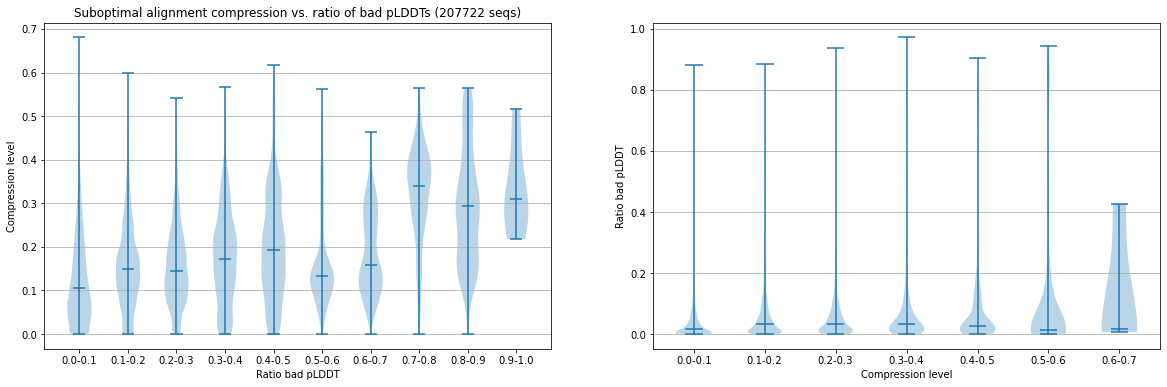

In [71]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(20, 6))


def violin_plot(ax, df_without_na, yprop, xprop, ytitle, xtitle, bucket_step_size=0.1, decimals=1):
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')][yprop].values for
               i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in
              buckets_indices]
    nans = [float('nan'), float('nan')]
    ax.violinplot(dataset=[bucket if bucket.any() else nans for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

df_without_na = df.dropna(subset=['suboptim_compress'])
ax1.set_title(f'Suboptimal alignment compression vs. ratio of bad pLDDTs ({len(df_without_na)} seqs)')
violin_plot(ax1, df_without_na, 'suboptim_compress', 'ratio_bad_plddt', 'Compression level', 'Ratio bad pLDDT')
violin_plot(ax2, df_without_na, 'ratio_bad_plddt', 'suboptim_compress', 'Ratio bad pLDDT', 'Compression level')

plt.show()

In [4]:
df_with_compression = df.dropna(subset=['suboptim_compress'])
df_with_compression.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,iupred_auc_normalized,ptm,suboptim_compress
count,207722.000000,0.0,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,0.0,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,207722.000000,5547.000000,207722.000000
mean,318.702213,NaN,49.850257,92.106795,94.850678,0.051014,0.243523,NaN,0.017321,1.023358,0.151669,0.148860,0.121173,0.525955,0.204012,6.984032,0.001313,0.840570,0.133778
std,204.207274,NaN,15.983216,5.340511,4.675161,0.080520,0.113509,NaN,0.199432,6.780007,0.054939,0.050548,0.034825,0.062268,0.038356,2.089213,0.001836,0.119868,0.101513
min,20.000000,NaN,15.410000,34.501000,27.080000,0.000000,0.000100,NaN,0.000000,0.000000,0.042600,0.013500,0.000000,0.241400,0.016900,4.050000,0.000000,0.218508,0.000000
25%,166.000000,NaN,36.850000,90.097725,93.840000,0.006600,0.179700,NaN,0.000000,0.000000,0.111500,0.121300,0.104600,0.488800,0.179300,5.320200,0.000500,0.809069,0.054900
50%,285.000000,NaN,47.500000,93.499950,96.170000,0.024800,0.235900,NaN,0.000000,0.000000,0.141300,0.138900,0.124400,0.522400,0.202800,6.045900,0.000700,0.880841,0.112800
75%,420.000000,NaN,60.820000,95.641000,97.570000,0.064500,0.299400,NaN,0.000000,0.000000,0.180400,0.162600,0.142400,0.557400,0.227300,8.967400,0.001400,0.915434,0.194200
max,2463.000000,NaN,95.510000,98.739800,98.850000,0.971900,0.965300,NaN,45.000000,243.000000,0.488300,0.500000,0.383800,0.932200,0.421100,12.000000,0.021900,0.957795,0.680400


In [18]:
worst_entries = df_with_compression.sort_values(by=['ratio_bad_plddt', 'median_plddt'], ascending=[False, True]).head(
    n=300)
best_entries = df_with_compression.sort_values(by=['ratio_bad_plddt', 'median_plddt'], ascending=[True, False]).head(
    n=300)

In [19]:
worst_clusters = worst_entries['cluster_id'].value_counts()
best_clusters = best_entries['cluster_id'].value_counts()

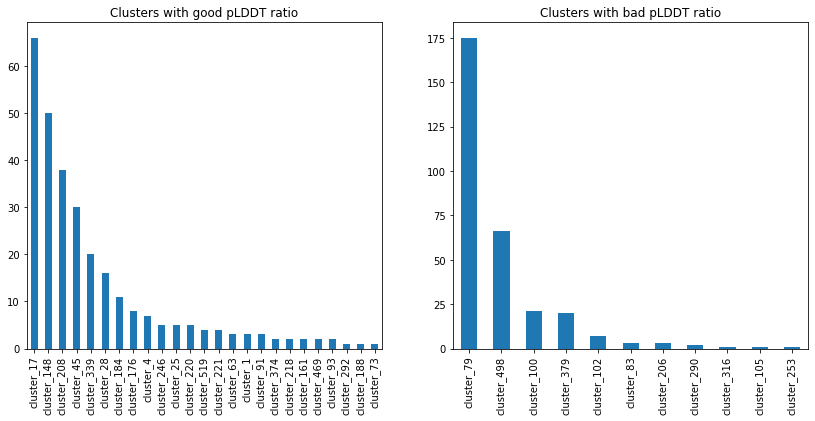

In [20]:
% matplotlib inline
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14, 6))

best_clusters[:25].plot(kind="bar", ax=ax1)
worst_clusters[:25].plot(kind="bar", ax=ax2)

ax1.set_title('Clusters with good pLDDT ratio')
ax2.set_title('Clusters with bad pLDDT ratio')

plt.show()

In [23]:
# Get some IDs for Vikram to investigate
worst_entries[['uniprot_id', 'ratio_bad_plddt', 'median_plddt', 'cluster_id']].to_csv(
    '../data/interesting_sequences/bad_plddt_cluster_entries.csv', index=False)
best_entries[['uniprot_id', 'ratio_bad_plddt', 'median_plddt', 'cluster_id']].to_csv(
    '../data/interesting_sequences/good_plddt_cluster_entries.csv', index=False)

### Investigate 500 most compressed regarding our properties
Compare the most compressed sequences with others to see if e.g. the IUPred AUC or other properties differ significantly

In [5]:
df_without_nan = df.drop(columns=['domain_count', 'iupred_plddt_spearman', 'iupred_auc'])
df_with_compression = df_without_nan.dropna(subset=['suboptim_compress'])
highest_compressed = df_with_compression.nlargest(n=500, columns=['suboptim_compress'])

In [18]:
df_with_compression[df_with_compression['suboptim_compress'] > 0.5]# ['cluster_id'].value_counts()

,uniprot_id,seq_len,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,iupred_auc_normalized,ptm,proteome,cluster_id,suboptim_compress
11,Q46XM7,963,37.92,93.9659,95.570,0.0125,0.0,0.0,0.0733,0.1485,0.1340,0.4974,0.2201,5.8750,0.0003,0.876213,SWISSPROT,cluster_488,0.5389
820,Q7VDV0,969,28.36,92.9837,94.810,0.0144,0.0,0.0,0.0984,0.1455,0.1311,0.4892,0.2343,6.2679,0.0002,0.868392,SWISSPROT,cluster_488,0.5284
1485,B9K8X3,918,74.20,95.1094,96.215,0.0000,0.0,0.0,0.1266,0.1732,0.1688,0.4706,0.1874,5.7514,0.0002,0.881158,SWISSPROT,cluster_488,0.5109
1913,A0AI82,469,27.41,84.3833,91.890,0.1834,0.0,4.0,0.1589,0.1557,0.1620,0.4733,0.2090,5.6103,0.0007,0.783838,SWISSPROT,cluster_120,0.5075
4903,C0QP76,947,54.48,94.7550,95.840,0.0021,0.0,1.0,0.1403,0.1732,0.1795,0.4762,0.1711,5.4896,0.0002,0.892727,SWISSPROT,cluster_488,0.5512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532973,P06306,110,39.16,53.8115,50.770,0.8545,0.0,0.0,0.1878,0.1091,0.1000,0.6091,0.1818,5.8622,0.0014,0.241573,SWISSPROT,cluster_100,0.5273
533216,A9NBM5,936,58.53,93.8153,95.080,0.0021,0.0,0.0,0.0660,0.1453,0.1357,0.5203,0.1987,5.9272,0.0002,0.884349,SWISSPROT,cluster_488,0.5032
535312,Q605M7,939,50.87,93.2463,94.610,0.0075,0.0,0.0,0.0861,0.1523,0.1395,0.5421,0.1661,5.8866,0.0002,0.830598,SWISSPROT,cluster_488,0.5091
536023,Q0TAY9,538,25.82,85.1853,96.455,0.1766,0.0,0.0,0.1404,0.1171,0.1264,0.4461,0.3104,5.2773,0.0005,0.759978,SWISSPROT,cluster_92,0.5112


In [22]:
highest_compressed[highest_compressed['cluster_id'] == 'cluster_488']

,uniprot_id,seq_len,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,iupred_auc_normalized,ptm,proteome,cluster_id,suboptim_compress
162012,Q5LNR7,970,34.98,93.6757,95.540,0.0103,0.0,0.0,0.0901,0.1443,0.1546,0.5165,0.1845,5.2656,0.0002,0.858766,SWISSPROT,cluster_488,0.6804
371172,A8A8T2,1022,50.55,93.5091,94.870,0.0068,0.0,0.0,0.1360,0.1614,0.1634,0.5049,0.1703,5.7502,0.0002,0.843416,SWISSPROT,cluster_488,0.6164
428171,Q3SPJ6,999,34.51,93.1752,95.010,0.0200,0.0,1.0,0.0802,0.1542,0.1411,0.5135,0.1912,6.1071,0.0003,0.826197,SWISSPROT,cluster_488,0.6006
169310,Q11NV4,1110,54.36,92.5849,94.200,0.0099,0.0,0.0,0.1054,0.1477,0.1468,0.4694,0.2360,5.8282,0.0002,0.841202,SWISSPROT,cluster_488,0.5937
519292,B1WVA3,959,38.40,93.6808,95.000,0.0052,0.0,0.0,0.0766,0.1408,0.1376,0.4755,0.2461,5.7129,0.0002,0.876945,SWISSPROT,cluster_488,0.5819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94214,Q3BP98,980,33.89,91.2868,94.660,0.0490,0.0,0.0,0.0832,0.1357,0.1388,0.5102,0.2153,5.4392,0.0003,0.856791,SWISSPROT,cluster_488,0.5041
445008,Q7N8X2,937,47.33,93.7474,94.840,0.0032,0.0,0.0,0.0611,0.1377,0.1334,0.5304,0.1985,5.6893,0.0002,0.885027,SWISSPROT,cluster_488,0.5037
33669,B6JNR5,920,48.84,92.8346,94.430,0.0109,0.0,0.0,0.1216,0.1685,0.1467,0.4685,0.2163,6.2808,0.0002,0.867687,SWISSPROT,cluster_488,0.5033
346329,Q8EUN9,900,51.56,93.4639,95.165,0.0078,0.0,0.0,0.1612,0.1667,0.1322,0.4467,0.2544,8.8640,0.0001,0.848305,SWISSPROT,cluster_488,0.5033


In [8]:
# Export for Fernando to check
df_with_compression[df_with_compression['suboptim_compress'] > 0.5]['cluster_id'].value_counts().to_csv('../data/interesting_sequences/most_compressed_clusters.csv')

In [20]:
df_means = pd.DataFrame([df_without_nan.mean(numeric_only=True), df_with_compression.mean(numeric_only=True), highest_compressed.mean(numeric_only=True)], index=['All', 'All with compression', 'Most compressed']).transpose()
pd.concat([pd.DataFrame([[str(len(df_without_nan)), str(len(df_with_compression)), str(len(highest_compressed))]], index=['count'], columns=['All', 'All with compression', 'Most compressed']), df_means])

,All,All with compression,Most compressed
count,1087298,207722,500
seq_len,313.0,285.0,607.5
min_plddt,35.19,47.5,45.44
mean_plddt,85.9651,93.49995,93.2169
median_plddt,92.46,96.17,95.0825
ratio_bad_plddt,0.1362,0.0248,0.01415
repeat_6mers_2000,0.0,0.0,0.0
non_repeat_6mers_2000,0.0,0.0,0.0
aa_distr_js,0.1457,0.1413,0.1083
freq_pos_charge,0.1369,0.1389,0.14005


### Add predicted TM score

In [64]:
# Add predicted TM score from file
df_ptm = pd.read_csv('../data/suboptimal/ptms.csv')

for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    if 'ptm' in proteome_df:
        continue
    proteome_df = proteome_df.merge(df_ptm, on="uniprot_id", how="left")
    l = len(proteome_df.dropna(subset=['ptm']))
    if l > 0:
        proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
        proteome_df.to_csv(proteome_file)

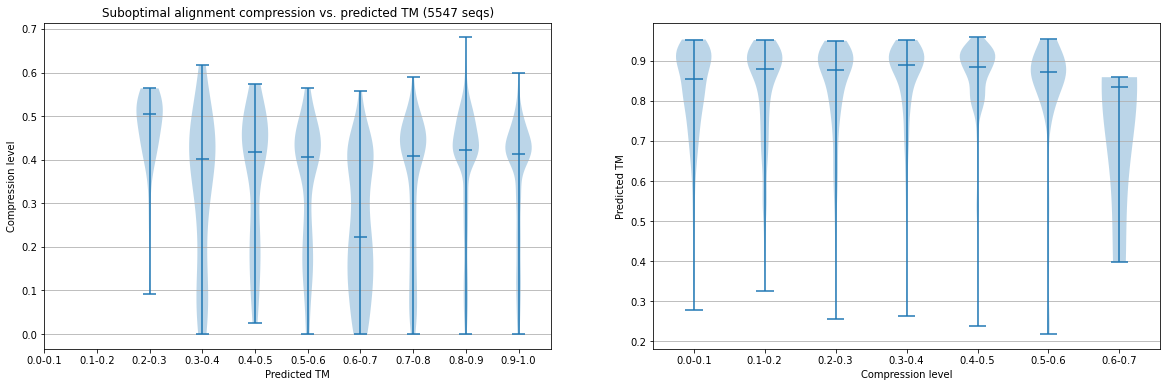

In [70]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(20, 6))


def violin_plot(ax, df_without_na, yprop, xprop, ytitle, xtitle, bucket_step_size=0.1, decimals=1):
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')][yprop].values for
               i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in
              buckets_indices]
    nans = [float('nan'), float('nan')]
    ax.violinplot(dataset=[bucket if bucket.any() else nans for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

df_without_na = df.dropna(subset=['suboptim_compress', 'ptm'])
ax1.set_title(f'Suboptimal alignment compression vs. predicted TM ({len(df_without_na)} seqs)')
violin_plot(ax1, df_without_na, 'suboptim_compress', 'ptm', 'Compression level', 'Predicted TM')
violin_plot(ax2, df_without_na, 'ptm', 'suboptim_compress', 'Predicted TM', 'Compression level')

plt.show()